## Data Preparation

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
RUN_GRIDSEARCH = False # Change to True to run GridSearchCVs, which I used for parameter tuning.

In [2]:
df = pd.read_csv('../data/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     284807 non-nu

no nulls

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df = df.rename(columns={"class": "fraud"})

In [7]:
# Checking for duplicates
df.groupby("fraud").apply(lambda x: x.duplicated().sum())

fraud
0    1062
1      19
dtype: int64

In [8]:
# Dropping duplicates
df = df.drop_duplicates().reset_index(drop=True)

In [9]:
fraud_rate = df["fraud"].mean()
fraud_rate

np.float64(0.001667101358352777)

### About the time variable

DB page says: Number of seconds elapsed between this transaction and the first transaction in the datase

As a result, I've decided to drop it, because it encodes dataset-relative elapsed time which would be unavailable at inference.

In [10]:
del df['time']

## Splits

In [11]:
# Split the data into train, validation, and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df["fraud"])
df_train , df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train["fraud"])

df_full_train.shape, df_train.shape, df_val.shape, df_test.shape

((226980, 30), (170235, 30), (56745, 30), (56746, 30))

In [12]:
# Reset index
df_full_train.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Target variable
y_full_train = df_full_train.fraud.values
y_train = df_train.fraud.values
y_val = df_val.fraud.values
y_test = df_test.fraud.values

# Delete target variable from dataframes
del df_train["fraud"]
del df_val["fraud"]
del df_test["fraud"]

## EDA

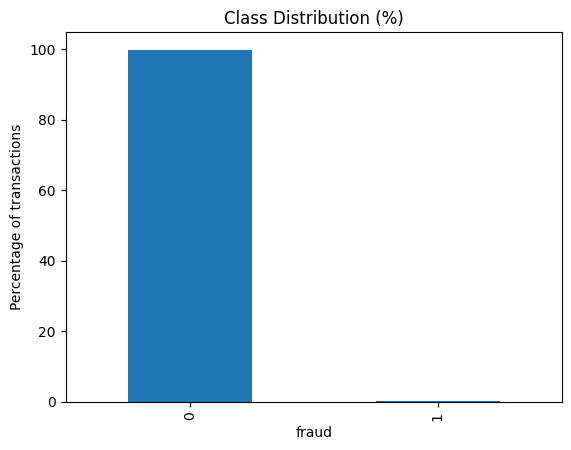

In [13]:
import matplotlib.pyplot as plt

(
    df_full_train["fraud"]
    .value_counts(normalize=True)
    .mul(100)
    .plot(kind="bar", title="Class Distribution (%)")
)

plt.ylabel("Percentage of transactions")
plt.show()

In [14]:
df_full_train["fraud"].value_counts().to_frame("count")

,count
fraud,
0,226602
1,378


The dataset is extremely imbalanced, with fraudulent transactions representing approximately 0.17% of the data. With this dataset, it's easy to achieve a very high accuracy. If I were to make a dummy model flagging 0 for every transaction, It'd have a 99.8% accuracy.

Therefore, accuracy is not an appropriate evaluation metric, and metrics such as Precision-Recall AUC are more informative.

### Let's check amount

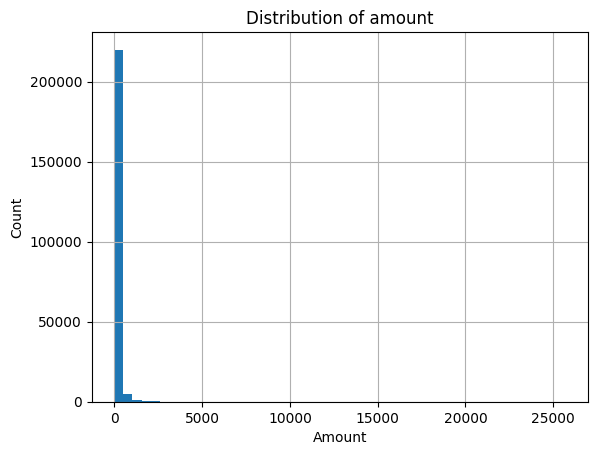

In [15]:
df_full_train["amount"].hist(bins = 50)
plt.title("Distribution of amount")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


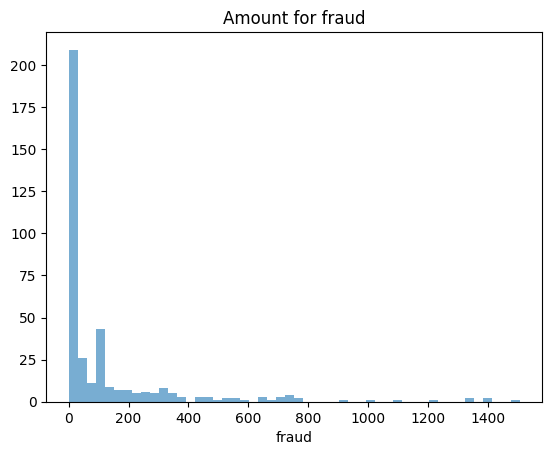

In [16]:
plt.hist(df_full_train[df_full_train["fraud"] == 1]["amount"], bins=50, alpha=0.6, label="amount")
plt.title("Amount for fraud")
plt.xlabel("fraud")
plt.show()

Nothing of note besides the fact that amount isn't high for any of the fraudulent transactions

### Correlation

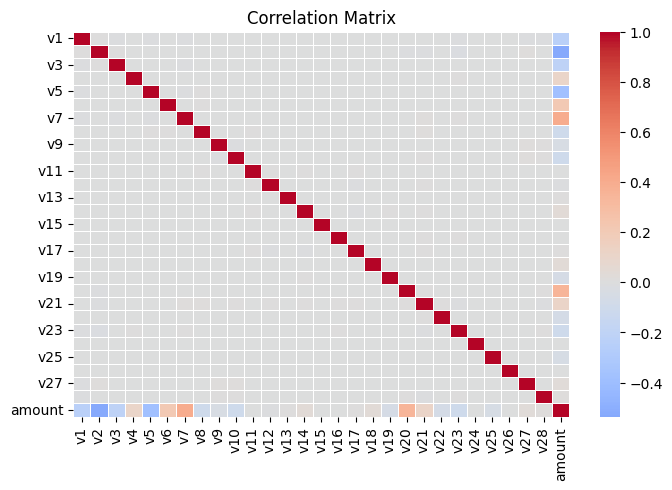

In [17]:
import seaborn as sns

corr = df_full_train.drop(columns='fraud').corr()

plt.figure(figsize=(8, 5))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
)

plt.title("Correlation Matrix")
plt.show()

No correlations between variables except amount

In [18]:
features = df_full_train.drop(columns="fraud").columns.to_list()

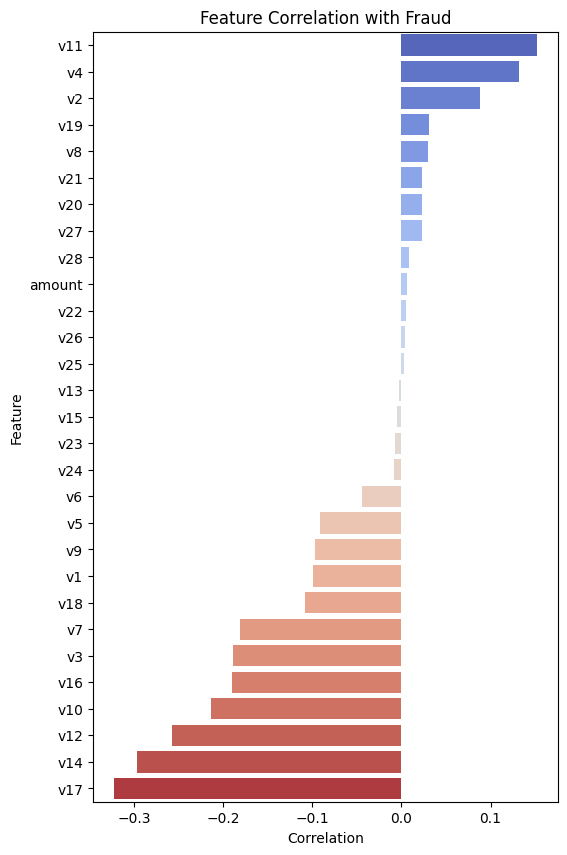

In [19]:
corr_with_target = (
    df_full_train[features + ["fraud"]]
    .corr()["fraud"]
    .drop("fraud")
    .sort_values(ascending=False)
)

plt.figure(figsize=(6, 10))
sns.barplot(
    x=corr_with_target.values,
    y=corr_with_target.index,
    hue=corr_with_target.index,
    palette="coolwarm"
)

plt.title("Feature Correlation with Fraud")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()


Some features exhibit low linear correlation with the target, which is expected given the PCA transformation applied to the original variables. This motivates the use of non-linear models such as Random Forests and Gradient Boosting, which can capture more complex relationships.

### Let's check KS

In [20]:
from scipy.stats import ks_2samp

ks_scores = {}

for col in features:
    fraud_vals = df_full_train[df_full_train["fraud"] == 1][col]
    nonfraud_vals = df_full_train[df_full_train["fraud"] == 0][col]
    ks = ks_2samp(fraud_vals, nonfraud_vals).statistic
    ks_scores[col] = ks

ks_scores = (
    pd.Series(ks_scores)
    .sort_values(ascending=False)
)

ks_scores.head(10)

v14    0.846416
v10    0.805194
v12    0.796491
v4     0.771047
v11    0.757433
v17    0.751563
v16    0.700304
v3     0.699169
v7     0.663969
v2     0.624214
dtype: float64

### V14 analysis

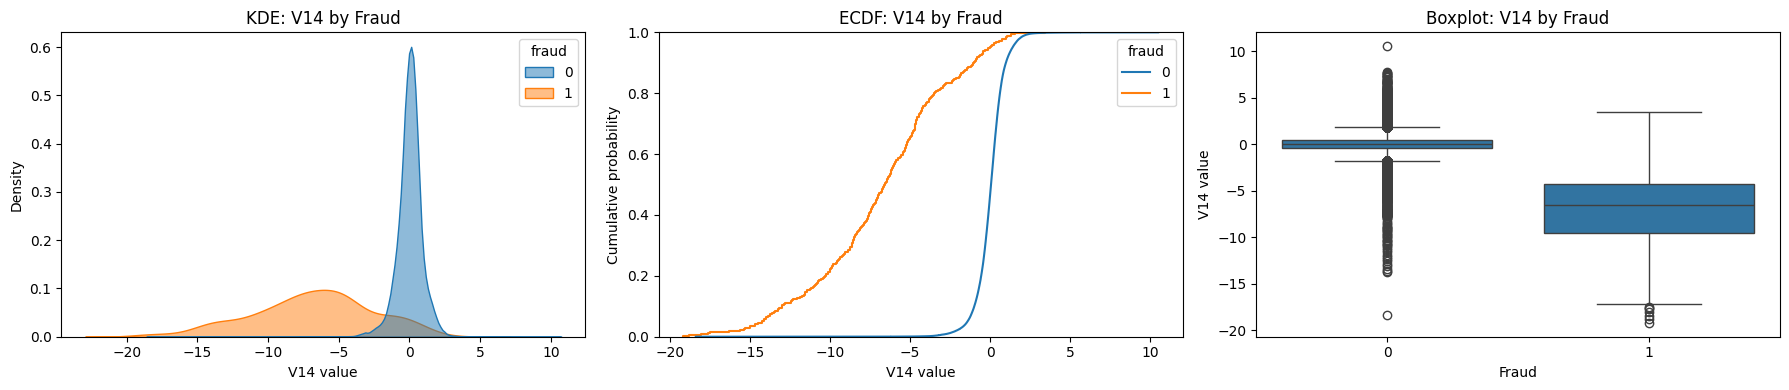

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# KDE plot
sns.kdeplot(
    data=df,
    x="v14",
    hue="fraud",
    common_norm=False,
    fill=True,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title("KDE: V14 by Fraud")
axes[0].set_xlabel("V14 value")
axes[0].set_ylabel("Density")

# ECDF plot
sns.ecdfplot(
    data=df,
    x="v14",
    hue="fraud",
    ax=axes[1]
)
axes[1].set_title("ECDF: V14 by Fraud")
axes[1].set_xlabel("V14 value")
axes[1].set_ylabel("Cumulative probability")

# Boxplot
sns.boxplot(
    data=df,
    x="fraud",
    y="v14",
    ax=axes[2]
)
axes[2].set_title("Boxplot: V14 by Fraud")
axes[2].set_xlabel("Fraud")
axes[2].set_ylabel("V14 value")

plt.tight_layout()
plt.show()

The plots above show that non-fraud transactions are heavily concentrated in a narrow range of V14 values, while fraud transactions are distributed elsewhere, with minimal overlap between the two classes.

This level of separation suggests that V14 is a highly informative feature for fraud detection.

### Let's check V2

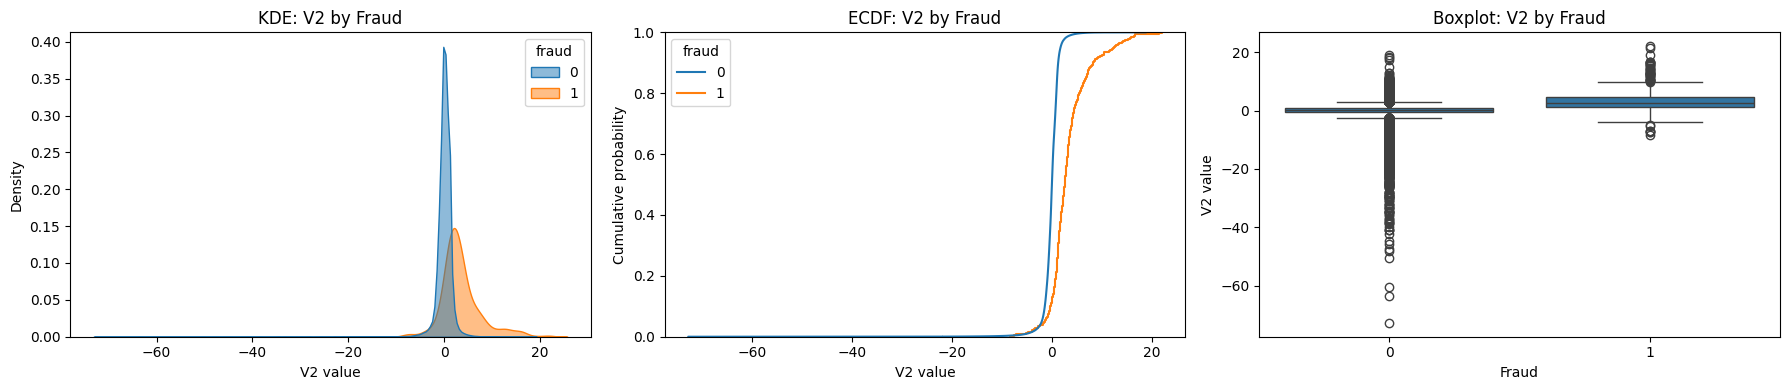

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# KDE plot
sns.kdeplot(
    data=df,
    x="v2",
    hue="fraud",
    common_norm=False,
    fill=True,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title("KDE: V2 by Fraud")
axes[0].set_xlabel("V2 value")
axes[0].set_ylabel("Density")

# ECDF plot
sns.ecdfplot(
    data=df,
    x="v2",
    hue="fraud",
    ax=axes[1]
)
axes[1].set_title("ECDF: V2 by Fraud")
axes[1].set_xlabel("V2 value")
axes[1].set_ylabel("Cumulative probability")

# Boxplot
sns.boxplot(
    data=df,
    x="fraud",
    y="v2",
    ax=axes[2]
)
axes[2].set_title("Boxplot: V2 by Fraud")
axes[2].set_xlabel("Fraud")
axes[2].set_ylabel("V2 value")

plt.tight_layout()
plt.show()

V2, the last of the ten variables with most separation, shows results similar to V14.

Also, checking these variables we can see how different they are from 'amount'. We'll use a StandardScaler to ensure that the weights aren't too different between the variables.

## Logistic regression

In [23]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

Because every variable is numerical, we don't need to use vectorizers for these models.

Check out my [churn_prediction_project](https://github.com/lautarocolli/machine-learning-zoomcamp-homework/blob/52037716cab92070cbcb595bd6246c900703708f/03-classification/churn_prediction_project.ipynb) from the ML Zoomcamp workshop to see a DictVectorizer implementation, which solves the problem of having categorical variables for these kinds of models using one-hot encoding.

In [24]:
pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(C = 1, max_iter=1000, random_state=1)
)
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict_proba(df_val)[:, 1]

ROC-AUC: 0.9891


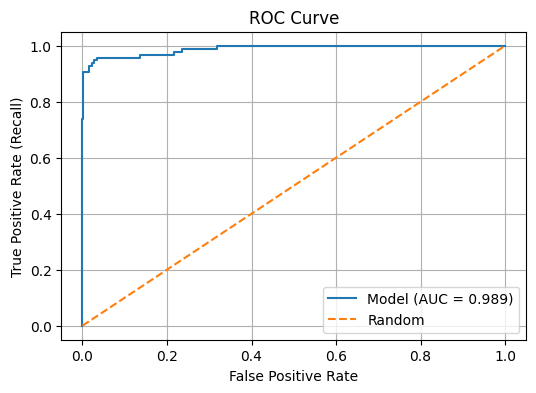

In [25]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

print(f"ROC-AUC: {auc:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

ROC_AUC_SCORE for Logistic Regression is 0.989, which is very close to ideal.

Let's try PR AUC, which should work better because of the imbalance of the dataset.

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

PR-AUC: 0.7977


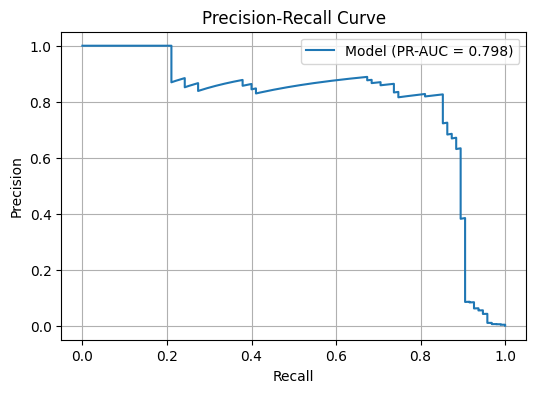

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
pr_auc = average_precision_score(y_val, y_pred)

print(f"PR-AUC: {pr_auc:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(
    recall,
    precision,
    label=f"Model (PR-AUC = {pr_auc:.3f})"
)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


PR-AUC is 0.798 with this model, let's try to improve on it by trying different C values.

Because of the insight it provides for this dataset, I'll be using PR-AUC for evaluation for the rest of the notebook.

We'll use GridSearch to tune the C value, using 5 folds and PR AUC as the optimization metric.

In [28]:
# Trying C values between 0.001 and 0.015 with a 0.001 step, 
#           between 0.1 and 1.01 with a 0.1 step, and
#           between 1 and 10 with a 1 step
from sklearn.model_selection import GridSearchCV

del df_full_train['fraud']
if RUN_GRIDSEARCH:
    Cs = np.concatenate([
        np.arange(0.001, 0.015, 0.001),
        np.arange(0.1, 1.01, 0.1),
        np.arange(1, 10.1, 1)
    ])

    param_grid = {
        "logisticregression__C": Cs
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring="average_precision",
        cv=5,
        n_jobs=-1
    )

    grid.fit(df_full_train, y_full_train)

    grid.best_params_, grid.best_score_


In [29]:
if RUN_GRIDSEARCH:
    optimal_C = grid.best_params_['logisticregression__C']
    optimal_C
if not(RUN_GRIDSEARCH):
    optimal_C = 0.1

In [30]:
pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(C = 0.1000, max_iter=1000, random_state=1)
)
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict_proba(df_val)[:, 1]
best_score = average_precision_score(y_val, y_pred)

print(
    f"Our best iteration of Logistic Regression achieves an average precision score of {best_score:.4f}, when C is {optimal_C:.5f}."
)

Our best iteration of Logistic Regression achieves an average precision score of 0.7916, when C is 0.10000.


In [31]:
from sklearn.model_selection import cross_val_score

for C in [1, optimal_C]:
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, max_iter=1000, random_state=1)
    )
    scores = cross_val_score(
        pipeline,
        df_full_train,
        y_full_train,
        cv=5,
        scoring="average_precision"
    )
    print(f'For C = {C:.4f}, average precision behaves = {scores.mean():.3f} +-{scores.std():.3f} on cross_val_score')

For C = 1.0000, average precision behaves = 0.751 +-0.024 on cross_val_score
For C = 0.1000, average precision behaves = 0.754 +-0.025 on cross_val_score


Pretty similar, but we'll stick to our calculated optimal C value because it's the smaller of the two, coefficients will be more stable.

In [32]:
# Training final regression model and looking at the coefs

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=optimal_C, max_iter=1000, random_state=1)
)

pipeline.fit(df_train, y_train)

coefs = pipeline.named_steps["logisticregression"].coef_[0]

df_coefs = pd.DataFrame({
    "feature": df_train.columns,
    "coef": coefs,
    "abs_coef": abs(coefs)
})

df_coefs = df_coefs.sort_values(by="abs_coef", ascending=False)
df_coefs.head(10)

,feature,coef,abs_coef
3,v4,0.653375,0.653375
13,v14,-0.567288,0.567288
9,v10,-0.387082,0.387082
15,v16,-0.256531,0.256531
7,v8,-0.242350,0.242350
21,v22,0.238577,0.238577
8,v9,-0.230059,0.230059
11,v12,-0.173854,0.173854
12,v13,-0.138974,0.138974
4,v5,0.136675,0.136675


## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rf = RandomForestClassifier(
    n_estimators = 100,
    random_state = 1,
    n_jobs=-1,
    class_weight='balanced_subsample' # because of class imbalance
)
rf.fit(df_train,y_train)
y_pred = rf.predict_proba(df_val)[:,1]
average_precision_score(y_val, y_pred)

0.8911793513619312

The precision score of this RF implementation is already much better than the Regression.

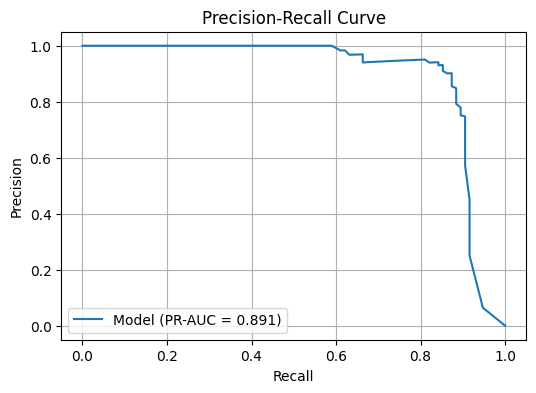

In [35]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
pr_auc = average_precision_score(y_val, y_pred)

plt.figure(figsize=(6, 4))
plt.plot(
    recall,
    precision,
    label=f"Model (PR-AUC = {pr_auc:.3f})"
)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

Let's tune it:

In [36]:
if RUN_GRIDSEARCH:
    n_ests = [50, 100, 200]
    max_ds = [5, 15, 30]
    min_s = [1, 10]

    param_grid = {
        "n_estimators": n_ests,
        "max_depth": max_ds,
        "min_samples_leaf": min_s
    }

    grid = GridSearchCV(
        rf,
        param_grid,
        scoring="average_precision",
        cv=3,
        n_jobs=-1
    )

    grid.fit(df_full_train, y_full_train)
    grid.best_params_, grid.best_score_

The best max_depth is a border value, let's try amplifying it and testing n_estimators around 100. min_samples_leaf stays at 1.

In [37]:
if RUN_GRIDSEARCH:
    n_ests = np.arange(70, 151, 10)
    max_ds = np.arange(20,51,10)
    min_samples_leaf = 1

    param_grid = {
        "n_estimators": n_ests,
        "max_depth": max_ds,
        "min_samples_leaf": [min_samples_leaf]
    }

    grid = GridSearchCV(
        rf,
        param_grid,
        scoring="average_precision",
        cv=3,
        n_jobs=-1
    )

    grid.fit(df_full_train, y_full_train)
    grid.best_params_, grid.best_score_

In [38]:
if RUN_GRIDSEARCH:
    results = pd.DataFrame(grid.cv_results_)

    results = results[[
        "param_n_estimators",
        "param_max_depth",
        "mean_test_score"
    ]]

    results.rename(columns={
        "mean_test_score": "pr_auc"
    }, inplace=True)

    results.head()

    plt.figure(figsize=(8, 5))

    sns.lineplot(
        data=results,
        x="param_n_estimators",
        y="pr_auc",
        hue="param_max_depth",
        marker="o",
        palette="tab10"
    )

    plt.title("PR-AUC vs n_estimators for different max_depth values")
    plt.xlabel("n_estimators")
    plt.ylabel("PR-AUC")
    plt.legend(title="max_depth")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [39]:
max_depth = 20
min_samples_leaf = 1
n_estimators = 80

rf = RandomForestClassifier(
    n_estimators = n_estimators,
    random_state = 1,
    min_samples_leaf = min_samples_leaf,
    max_depth = max_depth,
    n_jobs=-1,
    class_weight='balanced_subsample' # because of class imbalance
)

rf.fit(df_train,y_train)

# Let's check if it overfits:

train_pr = average_precision_score(
    y_train, rf.predict_proba(df_train)[:, 1]
)
val_pr = average_precision_score(
    y_val, rf.predict_proba(df_val)[:, 1]
)

train_pr, val_pr

(1.0, 0.8972209098924158)

In [40]:
cv_scores = cross_val_score(
    rf,
    df_full_train,
    y_full_train,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

cv_scores.mean(), cv_scores.std()

(np.float64(0.8394960993686679), np.float64(0.02608611936090513))

A 1.0 Train PR-AUC means that the model is memorizing training data to make predictions.

I'll try upping the min_samples_leaf to 10 and capping max_features.

In [41]:
rf = RandomForestClassifier(
    n_estimators = n_estimators,
    random_state = 1,
    min_samples_leaf = 10,
    max_features = 0.5,
    max_depth = max_depth,
    n_jobs=-1,
    class_weight='balanced_subsample' # because of class imbalance
)

rf.fit(df_train,y_train)

# Let's check if it overfits:

train_pr = average_precision_score(
    y_train, rf.predict_proba(df_train)[:, 1]
)
val_pr = average_precision_score(
    y_val, rf.predict_proba(df_val)[:, 1]
)

train_pr, val_pr

(0.9646354293322041, 0.8687206211515937)

It doesn't memorize, but still overfits.

In [42]:
cv_scores = cross_val_score(
    rf,
    df_full_train,
    y_full_train,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

cv_scores.mean(), cv_scores.std()

(np.float64(0.8206693298432584), np.float64(0.02702556011856853))

This model is not memorizing, but has a worse average_precision_score on validation dataset, and the cross val score has a lower mean and a higher std.

This suggests that the model that's memorizing is capturing meaningful patterns rather than noise, thus, I'll be keeping it as baseline.

In [43]:
rf = RandomForestClassifier(
    n_estimators = n_estimators,
    random_state = 1,
    min_samples_leaf = min_samples_leaf,
    max_depth = max_depth,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

rf.fit(df_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",80
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

## XGBoost

In [44]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    objective="binary:logistic",
    eval_metric="aucpr",
    random_state=1,
    n_jobs=-1
)

scores = cross_val_score(
    xgb,
    df_full_train,
    y_full_train,
    cv=5,
    scoring="average_precision"
)

scores.mean(), scores.std()

(np.float64(0.8530990468329895), np.float64(0.024498571631010678))

In [45]:
xgb.fit(
    df_train,
    y_train,
    eval_set=[(df_val, y_val)],
    verbose = False
)

train_pr = average_precision_score(y_train, xgb.predict_proba(df_train)[:, 1])
val_pr = average_precision_score(y_val, xgb.predict_proba(df_val)[:, 1])

train_pr , val_pr

(0.9999386533176285, 0.8844916929925377)

Memorizing again

In [46]:

if RUN_GRIDSEARCH:
    param_grid = {
        "max_depth": [3, 4, 5, 6],
        "min_child_weight": [1, 5, 10, 20],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1, 0.3]
    }

    grid = GridSearchCV(
        xgb,
        param_grid,
        scoring="average_precision",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_full_train, y_full_train)

    grid.best_params_, grid.best_score_

In [47]:
if RUN_GRIDSEARCH:
    xgb = XGBClassifier(
    n_estimators = 200,
    learning_rate = 0.05,

    colsample_bytree = 0.8,
    gamma = 0,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8,

    objective="binary:logistic",
    eval_metric="aucpr",

    random_state=1,
    n_jobs=-1
    )

    param_grid = {
        "learning_rate": [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]
    }

    grid = GridSearchCV(
        xgb,
        param_grid,
        scoring="average_precision",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_full_train, y_full_train)

    grid.best_params_, grid.best_score_

Best learning_rate is 0.05. Now for n_estimators, let's see where this plateaus:

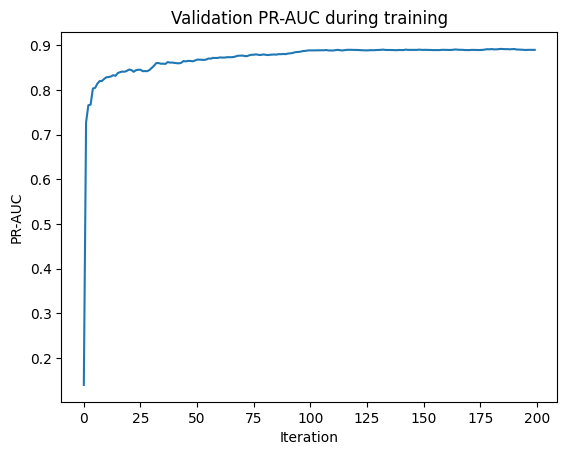

In [48]:
xgb = XGBClassifier(
    n_estimators = 200,
    learning_rate = 0.05,

    colsample_bytree = 0.8,
    gamma = 0,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8,

    objective="binary:logistic",
    eval_metric="aucpr",
    
    random_state=1,
    n_jobs=-1
)

xgb.fit(
    df_train,
    y_train,
    eval_set=[(df_val, y_val)],
    verbose = False
)

results = xgb.evals_result()

plt.plot(results["validation_0"]["aucpr"])
plt.xlabel("Iteration")
plt.ylabel("PR-AUC")
plt.title("Validation PR-AUC during training")
plt.show()

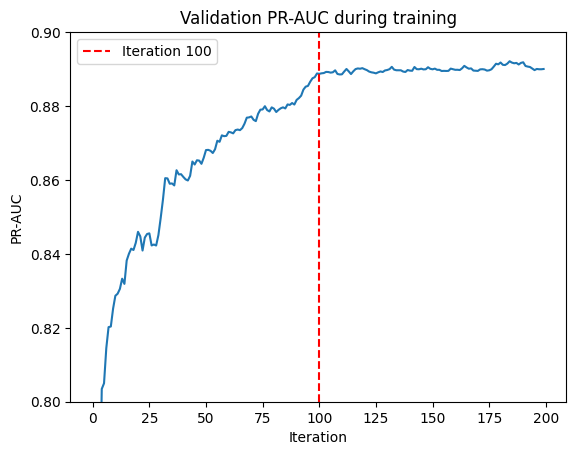

In [49]:
# Let's zoom in
plt.plot(results["validation_0"]["aucpr"])

plt.axvline(
    x=100,
    color="red",
    linestyle="--",
    label="Iteration 100"
)

plt.xlabel("Iteration")
plt.ylabel("PR-AUC")
plt.ylim(0.8, 0.9)
plt.title("Validation PR-AUC during training")
plt.legend()
plt.show()


Marginal gains after iter 100

In [50]:
xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.05,

    colsample_bytree = 0.8,
    gamma = 0,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8,

    objective="binary:logistic",
    eval_metric="aucpr",
    
    random_state=1,
    n_jobs=-1
)

xgb.fit(
    df_train,
    y_train,
    eval_set=[(df_val, y_val)],
    verbose = False
)

train_pr = average_precision_score(y_train, xgb.predict_proba(df_train)[:, 1])
val_pr = average_precision_score(y_val, xgb.predict_proba(df_val)[:, 1])

train_pr , val_pr

(0.9782147941470757, 0.8890175890977391)

Model doesn't seem to be memorizing completely, and has a good PR. Let's see how it performs with CV:

In [51]:
cv_scores = cross_val_score(
    xgb,
    df_full_train,
    y_full_train,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

cv_scores.mean(), cv_scores.std()

(np.float64(0.8593260589785501), np.float64(0.025685923064586277))

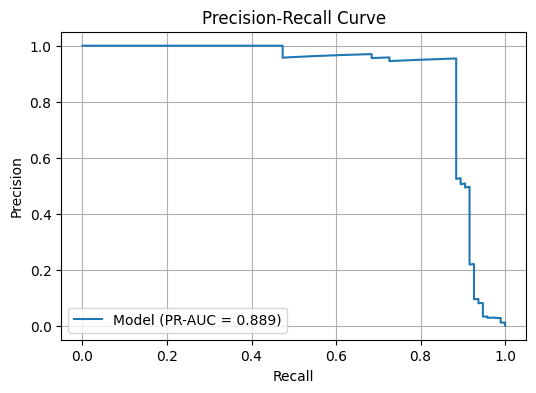

In [52]:
precision, recall, thresholds = precision_recall_curve(y_val, xgb.predict_proba(df_val)[:, 1])
pr_auc = average_precision_score(y_val, xgb.predict_proba(df_val)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(
    recall,
    precision,
    label=f"Model (PR-AUC = {pr_auc:.3f})"
)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

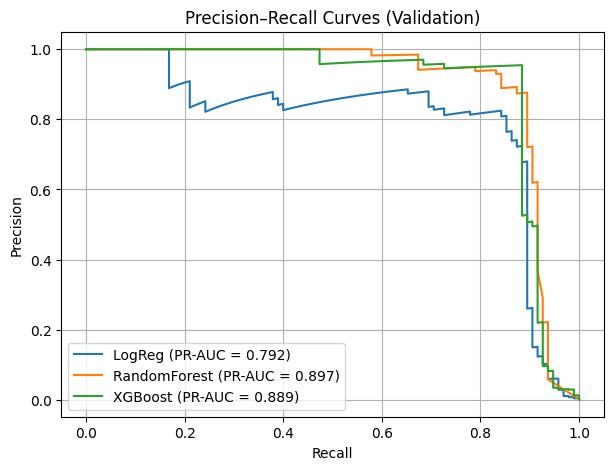

In [53]:
plt.figure(figsize=(7, 5))

models = {
    "LogReg": pipeline,
    "RandomForest": rf,
    "XGBoost": xgb
}

for name, model in models.items():
    y_pred = model.predict_proba(df_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    plt.plot(
        recall,
        precision,
        label=f"{name} (PR-AUC = {pr_auc:.3f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Validation)")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
for name, model in models.items():
    cv_scores = cross_val_score(
        model,
        df_full_train,
        y_full_train,
        scoring="average_precision",
        cv=5,
        n_jobs=-1
    )

    print(
        f"{name}: "
        f"mean PR-AUC = {cv_scores.mean():.3f}, "
        f"std = {cv_scores.std():.3f}"
    )

LogReg: mean PR-AUC = 0.754, std = 0.025
RandomForest: mean PR-AUC = 0.839, std = 0.026
XGBoost: mean PR-AUC = 0.859, std = 0.026


In [55]:
for name, model in models.items():
    y_pred = model.predict_proba(df_val)[:, 1]
    pr_auc = average_precision_score(y_val, y_pred)

    print(f"{name}: Validation PR-AUC = {pr_auc:.3f}")

LogReg: Validation PR-AUC = 0.792
RandomForest: Validation PR-AUC = 0.897
XGBoost: Validation PR-AUC = 0.889


In [ ]:
for name, model in models.items():
    y_pred = model.predict_proba(df_val)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

    # thresholds has length n-1 → align arrays
    precision = precision[:-1]
    recall = recall[:-1]

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

    best_idx = np.argmax(f1_scores)

    print(
        f"{name}: "
        f"Best F1 = {f1_scores[best_idx]:.3f} | "
        f"Precision = {precision[best_idx]:.3f} | "
        f"Recall = {recall[best_idx]:.3f} | "
        f"Threshold = {thresholds[best_idx]:.3f}"
    )

LogReg: Best F1 = 0.833 | Precision = 0.825 | Recall = 0.842 | Threshold = 0.131
RandomForest: Best F1 = 0.885 | Precision = 0.876 | Recall = 0.895 | Threshold = 0.162
XGBoost: Best F1 = 0.918 | Precision = 0.955 | Recall = 0.884 | Threshold = 0.353


Although XGBoost and Random Forest achieve similar PR-AUC values,

XGBoost shows more stable cross-validation performance and maintains higher precision at high-recall operating points.

Since the objective is to maximize fraud detection while controlling false positives, XGBoost is selected as the final model, with a threshold of 0.353

The threshold may be adjusted based on business tolerance for false positives vs false negatives

In [62]:
xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.05,

    colsample_bytree = 0.8,
    gamma = 0,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 0.8,

    objective="binary:logistic",
    eval_metric="aucpr",
    
    random_state=1,
    n_jobs=-1
)

xgb.fit(
    df_full_train,
    y_full_train,
)

y_pred = xgb.predict_proba(df_test)[:,1]
pr_auc = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

pr_auc , roc_auc

(0.8016488952463168, 0.9621412359516114)

In [63]:
threshold = 0.353

y_pred_proba = xgb.predict_proba(df_test)[:, 1]
y_pred_label = (y_pred_proba >= threshold).astype(int)

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_label).ravel()

tp, fp, fn, tn


(np.int64(72), np.int64(6), np.int64(23), np.int64(56645))

In [64]:
print("Precision:", tp / (tp + fp))
print("Recall:", tp / (tp + fn))

Precision: 0.9230769230769231
Recall: 0.7578947368421053


In [ ]:
from sklearn.metrics import precision_score, recall_score

for t in [0.25, 0.30, 0.35]:
    y_pred = (y_pred_proba >= t).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"t={t:.2f} | Precision={precision:.3f} | Recall={recall:.3f}")

t=0.25 | Precision=0.912 | Recall=0.768
t=0.30 | Precision=0.924 | Recall=0.768
t=0.35 | Precision=0.923 | Recall=0.758


We settle on t = 0.3

In [67]:
threshold = 0.3

y_pred_proba = xgb.predict_proba(df_test)[:, 1]
y_pred_label = (y_pred_proba >= threshold).astype(int)

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_label).ravel()

tp, fp, fn, tn

(np.int64(73), np.int64(6), np.int64(22), np.int64(56645))

In [68]:
print("Precision:", tp / (tp + fp))
print("Recall:", tp / (tp + fn))

Precision: 0.9240506329113924
Recall: 0.7684210526315789
